In [1]:
import pandas as pd
import numpy as np
from random import choice
from glob import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_ind

plt.style.use('ggplot')

In [2]:
pred_root = "../../data/output/xgbooster/API/"
report_root = "../../data/csv/api/"
monitor_root = "../../data/csv/monitor/"

## Match and save data

In [3]:
# load reporting data
report = pd.read_csv(os.path.join(report_root, "china_api_processed.csv"))
report = report.drop('city_cn', axis=1)
report.set_index(['city_id', 'date'], inplace=True)

In [4]:
# load monitoring station info
monitor = pd.read_csv(os.path.join(monitor_root, "monitor_processed.csv"))
monitor = monitor[['id', 'city_id']]
monitor.set_index('id', inplace=True)

In [5]:
# load predictions
pred = pd.read_csv(os.path.join(pred_root, "prediction_output.csv"))
pred.set_index('id', inplace=True)
pred = pred.join(monitor)

In [6]:
pred = pred.groupby(['city_id', 'date'])[['pred']].mean()

In [7]:
# match
df = pred.join(report)
df = df.dropna()
df = df.sort_index(level=['city_id', 'date'])

In [8]:
df.to_csv(os.path.join(pred_root, "api_matched.csv"))

## Plot trends and distributions

In [9]:
df = pd.read_csv(os.path.join(pred_root, "api_matched.csv"))
df['date'] = pd.to_datetime(df['date'])
df.set_index(['city_id', 'date'], inplace=True)
city_ids = df.index.get_level_values('city_id').unique().tolist()

In [16]:
# or specify city_id
city_id = 18

In [17]:
# city_id = choice(city_ids)

In [18]:
tmp = df.loc[(city_id, slice(None)), :].reset_index()

print("t-test p-values: {:.6f}; ks-test p-values: {:.6f}".format(
    ttest_ind(tmp.pred, tmp.report_API, equal_var=False)[1],
    ks_2samp(tmp.pred, tmp.report_API)[1]))

t-test p-values: 0.000000; ks-test p-values: 0.000000


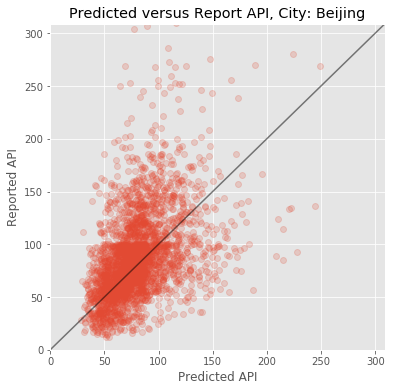

In [19]:
upper = np.maximum(np.percentile(tmp.pred, 99), np.percentile(tmp.report_API, 99))

plt.figure(figsize=(6, 6))
plt.plot(tmp.pred, tmp.report_API, 'o', alpha=0.2)
plt.xlim(0, upper)
plt.ylim(0, upper)
plt.plot([0, upper], [0, upper], 'k-', alpha=0.5)
plt.title("Predicted versus Report API, City: {}".format(tmp.city_en.unique()[0]))
plt.xlabel("Predicted API")
plt.ylabel("Reported API")
plt.show()

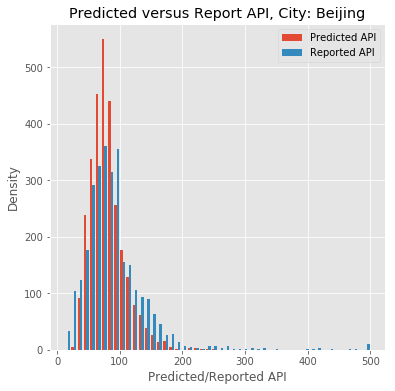

In [20]:
plt.figure(figsize=(6, 6))
plt.hist(tmp[['pred', 'report_API']].values, label=['Predicted API', 'Reported API'], bins=50)
plt.title("Predicted versus Report API, City: {}".format(tmp.city_en.unique()[0]))
plt.xlabel("Predicted/Reported API")
plt.ylabel("Density")
plt.legend()
plt.show()

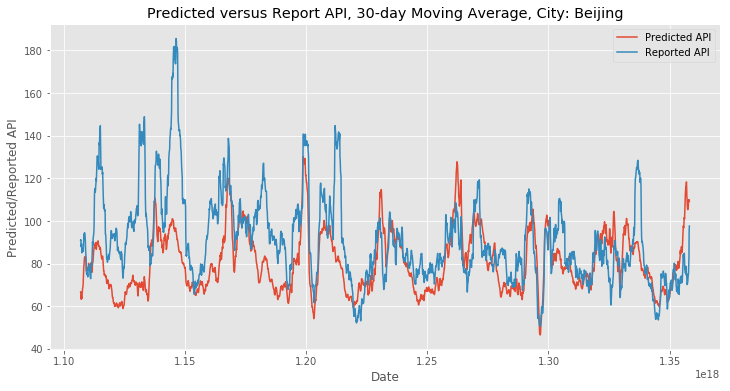

In [21]:
plot_window = 30

plt.figure(figsize=(12, 6))
plt.plot(tmp.date, tmp.pred.rolling(window=plot_window).mean(), label="Predicted API")
plt.plot(tmp.date, tmp.report_API.rolling(window=plot_window).mean(), label="Reported API")
plt.title("Predicted versus Report API, {}-day Moving Average, City: {}".format(
    plot_window,
    tmp.city_en.unique()[0]))
plt.xlabel("Date")
plt.ylabel("Predicted/Reported API")
plt.legend()
plt.show()